In [1]:
import unicodedata
import string
import re
import random
import time
import datetime
import math
import socket
hostname = socket.gethostname()

import torch
import torch.nn as nn
from torch.autograd import Variable
from torch import optim
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_packed_sequence, pack_padded_sequence
from masked_cross_entropy import *

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
%matplotlib inline

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
SOS_token = 0
EOS_token = 1

class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2 # Count SOS and EOS
      
    def index_words(self, sentence):
        for word in sentence.split(' '):
            self.index_word(word)

    def index_word(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [3]:
''' Строчные буквы, обрезать и удалить небуквенные символы '''
def normalize_string(s):
    s = s.lower().strip()
    s = re.sub(r"([,.!?])", r"", s)
    return s

In [4]:
def read_langs(lang1, lang2, reverse=False):
    print("Reading lines...")

    filename = '%s-%s.txt' % (lang1, lang2)
    lines = open(filename, encoding='utf-8').read().strip().split('\n')

    ''' Разделение строк на пары и нормализация '''
    pairs = [[normalize_string(s) for s in l.split('\t')] for l in lines]

    ''' Переворот пар, создавание экземпляров класса Lang ''' 
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

In [5]:
MIN_LENGTH = 3
MAX_LENGTH = 25

def filter_pairs(pairs):
    filtered_pairs = []
    for pair in pairs:
        if len(pair[0]) >= MIN_LENGTH and len(pair[0]) <= MAX_LENGTH \
            and len(pair[1]) >= MIN_LENGTH and len(pair[1]) <= MAX_LENGTH:
                filtered_pairs.append(pair)
    return filtered_pairs

In [6]:
def prepare_data(lang1_name, lang2_name, reverse=False, filter_pairs_flag=False):
    input_lang, output_lang, pairs = read_langs(lang1_name, lang2_name, reverse)
    print('Read %d sentence pairs' % len(pairs))
    
    if(filter_pairs_flag):
        pairs = filter_pairs(pairs)
    print('Отфильтровано пар: %d' % len(pairs))
    
    print('Индексирование слов...')
    for pair in pairs:
        for u in pair[0].split():
            input_lang.index_word(u)
        for u in pair[1].split():
            output_lang.index_word(u)
    
    print('Индексированных %d слов на входном языке, %d слов на выходном' % (input_lang.n_words, output_lang.n_words))
    return input_lang, output_lang, pairs

input_lang, output_lang, pairs = prepare_data('rus', 'eng', False)

Reading lines...
Read 621481 sentence pairs
Отфильтровано пар: 621481
Индексирование слов...
Индексированных 95134 слов на входном языке, 35713 слов на выходном


In [7]:
keep_pairs = []

for pair in pairs:
    input_sentence = pair[0]
    output_sentence = pair[1]
    keep_input = True
    keep_output = True
    
    for word in input_sentence.split(' '):
        if word not in input_lang.word2index:
            keep_input = False
            break

    for word in output_sentence.split(' '):
        if word not in output_lang.word2index:
            keep_output = False
            break

    ''' Удаление пар если они не соответствуют условиям ввода и вывода ''' 
    if keep_input and keep_output:
        keep_pairs.append(pair)
        
print("Отброшено %d пар до %d, %.4f от общего числа" % (len(pairs), len(keep_pairs), len(keep_pairs) / len(pairs)))
pairs = keep_pairs

Отброшено 621481 пар до 621119, 0.9994 от общего числа


In [8]:
''' Возвращает список индексов, по одному для каждого слова в предложении, плюс EOS '''
def indexes_from_sentence(lang, sentence):
    rez = []
    for word in sentence.split(' '):
        if word not in lang.word2index:
            lang.word2index[word] = lang.n_words
            lang.index2word[lang.n_words] = word
            lang.n_words += 1
        rez.append(lang.word2index[word])
        
    rez.append(EOS_token)     
    return rez

In [9]:
def variable_from_sentence(lang, sentence):
    indexes = indexes_from_sentence(lang, sentence)
    indexes.append(EOS_token)
    var = Variable(torch.LongTensor(indexes).view(-1, 1))
    var = var.to(device)
    return var

In [10]:
def variables_from_pair(pair):
    input_variable = variable_from_sentence(input_lang, pair[0])
    target_variable = variable_from_sentence(output_lang, pair[1])
    return (input_variable, target_variable)

# Encoder

In [11]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, n_layers=1):
        super(EncoderRNN, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers)
        
    def forward(self, word_inputs, hidden):
        # Note: we run this all at once (over the whole input sequence)
        seq_len = len(word_inputs)
        embedded = self.embedding(word_inputs).view(seq_len, 1, -1)
        output, hidden = self.gru(embedded, hidden)
        return output, hidden

    def init_hidden(self):
        hidden = Variable(torch.zeros(self.n_layers, 1, self.hidden_size))
        hidden = hidden.to(device)
        return hidden

In [12]:
class Attn(nn.Module):
    def __init__(self, method, hidden_size, max_length=MAX_LENGTH):
        super(Attn, self).__init__()
        
        self.method = method
        self.hidden_size = hidden_size
        
        if self.method == 'general':
            self.attn = nn.Linear(self.hidden_size, hidden_size)

        elif self.method == 'concat':
            self.attn = nn.Linear(self.hidden_size * 2, hidden_size)
            self.other = nn.Parameter(torch.FloatTensor(1, hidden_size))

    def forward(self, hidden, encoder_outputs):
        seq_len = len(encoder_outputs)

        # Create variable to store attention energies
        attn_energies = Variable(torch.zeros(seq_len)) # B x 1 x S
        attn_energies = attn_energies.to(device)

        # Calculate energies for each encoder output
        for i in range(seq_len):
            attn_energies[i] = self.score(hidden, encoder_outputs[i])

        # Normalize energies to weights in range 0 to 1, resize to 1 x 1 x seq_len
        return F.softmax(attn_energies).unsqueeze(0).unsqueeze(0)
    
    def score(self, hidden, encoder_output):
        if self.method == 'dot':
            energy =torch.dot(hidden.view(-1), encoder_output.view(-1))
        elif self.method == 'general':
            energy = self.attn(encoder_output)
            energy = torch.dot(hidden.view(-1), energy.view(-1))
        elif self.method == 'concat':
            energy = self.attn(torch.cat((hidden, encoder_output), 1))
            energy = torch.dot(self.v.view(-1), energy.view(-1))
        return energy

In [13]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, attn_model, hidden_size, output_size, n_layers=1, dropout_p=0.1):
        super(AttnDecoderRNN, self).__init__()
        
        # Keep parameters for reference
        self.attn_model = attn_model
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.dropout_p = dropout_p
        
        # Define layers
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size * 2, hidden_size, n_layers, dropout=dropout_p)
        self.out = nn.Linear(hidden_size * 2, output_size)
        
        # Choose attention model
        if attn_model != 'none':
            self.attn = Attn(attn_model, hidden_size)
    
    def forward(self, word_input, last_context, last_hidden, encoder_outputs):
        # Note: we run this one step at a time
        
        # Get the embedding of the current input word (last output word)
        word_embedded = self.embedding(word_input).view(1, 1, -1) # S=1 x B x N
        
        # Combine embedded input word and last context, run through RNN
        rnn_input = torch.cat((word_embedded, last_context.unsqueeze(0)), 2)
        rnn_output, hidden = self.gru(rnn_input, last_hidden)

        # Calculate attention from current RNN state and all encoder outputs; apply to encoder outputs
        attn_weights = self.attn(rnn_output.squeeze(0), encoder_outputs)
        context = attn_weights.bmm(encoder_outputs.transpose(0, 1)) # B x 1 x N
        
        # Final output layer (next word prediction) using the RNN hidden state and context vector
        rnn_output = rnn_output.squeeze(0) # S=1 x B x N -> B x N
        context = context.squeeze(1)       # B x S=1 x N -> B x N
        output = F.log_softmax(self.out(torch.cat((rnn_output, context), 1)))
        
        # Return final output, hidden state, and attention weights (for visualization)
        return output, context, hidden, attn_weights

In [14]:
encoder_test = EncoderRNN(10, 10, 2)
decoder_test = AttnDecoderRNN('general', 10, 10, 2)
print(encoder_test)
print(decoder_test)

encoder_hidden = encoder_test.init_hidden()
word_input = Variable(torch.LongTensor([1, 2, 3]))

encoder_test.to(device)
word_input = word_input.to(device)
    
encoder_outputs, encoder_hidden = encoder_test(word_input, encoder_hidden)

word_inputs = Variable(torch.LongTensor([1, 2, 3]))
decoder_attns = torch.zeros(1, 3, 3)
decoder_hidden = encoder_hidden
decoder_context = Variable(torch.zeros(1, decoder_test.hidden_size))

decoder_test.to(device)
word_inputs = word_inputs.to(device)
decoder_context = decoder_context.to(device)

for i in range(3):
    decoder_output, decoder_context, decoder_hidden, decoder_attn = decoder_test(word_inputs[i], decoder_context, decoder_hidden, encoder_outputs)
    print(decoder_output.size(), decoder_hidden.size(), decoder_attn.size())
    decoder_attns[0, i] = decoder_attn.squeeze(0).cpu().data

EncoderRNN(
  (embedding): Embedding(10, 10)
  (gru): GRU(10, 10, num_layers=2)
)
AttnDecoderRNN(
  (embedding): Embedding(10, 10)
  (gru): GRU(20, 10, num_layers=2, dropout=0.1)
  (out): Linear(in_features=20, out_features=10, bias=True)
  (attn): Attn(
    (attn): Linear(in_features=10, out_features=10, bias=True)
  )
)
torch.Size([1, 10]) torch.Size([2, 1, 10]) torch.Size([1, 1, 3])
torch.Size([1, 10]) torch.Size([2, 1, 10]) torch.Size([1, 1, 3])
torch.Size([1, 10]) torch.Size([2, 1, 10]) torch.Size([1, 1, 3])


C:\Users\ONIGAT~1\AppData\Local\Temp/ipykernel_24024/1211660399.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(attn_energies).unsqueeze(0).unsqueeze(0)
C:\Users\ONIGAT~1\AppData\Local\Temp/ipykernel_24024/290874258.py:38: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.log_softmax(self.out(torch.cat((rnn_output, context), 1)))


In [15]:
teacher_forcing_ratio = 0.5
clip = 5.0

def train(input_variable, target_variable, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):

    # Zero gradients of both optimizers
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()
    loss = 0 # Added onto for each word

    # Get size of input and target sentences
    input_length = input_variable.size()[0]
    target_length = target_variable.size()[0]

    # Run words through encoder
    encoder_hidden = encoder.init_hidden()
    encoder_outputs, encoder_hidden = encoder(input_variable, encoder_hidden)
    
    # Prepare input and output variables
    decoder_input = Variable(torch.LongTensor([[SOS_token]]))
    decoder_context = Variable(torch.zeros(1, decoder.hidden_size))
    decoder_hidden = encoder_hidden # Use last hidden state from encoder to start decoder
    decoder_input = decoder_input.to(device)
    decoder_context = decoder_context.to(device)

    # Choose whether to use teacher forcing
    use_teacher_forcing = random.random() < teacher_forcing_ratio
    if use_teacher_forcing:
        
        # Teacher forcing: Use the ground-truth target as the next input
        for di in range(target_length):
            decoder_output, decoder_context, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_context, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_variable[di])
            decoder_input = target_variable[di] # Next target is next input

    else:
        # Without teacher forcing: use network's own prediction as the next input
        for di in range(target_length):
            decoder_output, decoder_context, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_context, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_variable[di])
            
            # Get most likely word index (highest value) from output
            topv, topi = decoder_output.data.topk(1)
            ni = topi[0][0]
            
            decoder_input = Variable(torch.LongTensor([[ni]])) # Chosen word is next input
            decoder_input = decoder_input.to(device)

            # Stop at end of sentence (not necessary when using known targets)
            if ni == EOS_token: break

    # Backpropagation
    loss.backward()
    torch.nn.utils.clip_grad_norm(encoder.parameters(), clip)
    torch.nn.utils.clip_grad_norm(decoder.parameters(), clip)
    encoder_optimizer.step()
    decoder_optimizer.step()
    
    return loss.data / target_length

In [16]:
def as_minutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def time_since(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (as_minutes(s), as_minutes(rs))

In [17]:
attn_model = 'general'
hidden_size = 500
n_layers = 2
dropout_p = 0.05

# Initialize models
encoder = EncoderRNN(input_lang.n_words, hidden_size, n_layers)
decoder = AttnDecoderRNN(attn_model, hidden_size, output_lang.n_words, n_layers, dropout_p=dropout_p)

# Move models to GPU
encoder.to(device)
decoder.to(device)

# Initialize optimizers and criterion
learning_rate = 0.0001
encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
criterion = nn.NLLLoss()

In [18]:
# Configuring training
n_epochs = 50000
plot_every = 200
print_every = 1000

# Keep track of time elapsed and running averages
start = time.time()
plot_losses = []
print_loss_total = 0 # Reset every print_every
plot_loss_total = 0 # Reset every plot_every

In [19]:
for epoch in range(1, n_epochs + 1):
    
    # Get training data for this cycle
    training_pair = variables_from_pair(random.choice(pairs))
    input_variable = training_pair[0]
    target_variable = training_pair[1]

    # Run the train function
    loss = train(input_variable, target_variable, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)

    # Keep track of loss
    print_loss_total += loss
    plot_loss_total += loss

    if epoch == 0: continue

    if epoch % print_every == 0:
        print_loss_avg = print_loss_total / print_every
        print_loss_total = 0
        print_summary = '%s (%d %d%%) %.4f' % (time_since(start, epoch / n_epochs), epoch, epoch / n_epochs * 100, print_loss_avg)
        print(print_summary)

    if epoch % plot_every == 0:
        plot_loss_avg = plot_loss_total / plot_every
        plot_losses.append(plot_loss_avg)
        plot_loss_total = 0

C:\Users\ONIGAT~1\AppData\Local\Temp/ipykernel_24024/1211660399.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(attn_energies).unsqueeze(0).unsqueeze(0)
C:\Users\ONIGAT~1\AppData\Local\Temp/ipykernel_24024/290874258.py:38: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.log_softmax(self.out(torch.cat((rnn_output, context), 1)))
C:\Users\ONIGAT~1\AppData\Local\Temp/ipykernel_24024/3538393260.py:54: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(encoder.parameters(), clip)
C:\Users\ONIGAT~1\AppData\Local\Temp/ipykernel_24024/3538393260.py:55: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(decoder.parameters(), clip)


1m 24s (- 69m 14s) (1000 2%) 4.4270
2m 54s (- 69m 48s) (2000 4%) 4.1982
4m 25s (- 69m 12s) (3000 6%) 4.0201
5m 53s (- 67m 43s) (4000 8%) 3.9617
7m 22s (- 66m 18s) (5000 10%) 3.8150
8m 51s (- 64m 59s) (6000 12%) 3.8292
10m 20s (- 63m 32s) (7000 14%) 3.6713
11m 49s (- 62m 4s) (8000 16%) 3.6230
13m 19s (- 60m 42s) (9000 18%) 3.6932
14m 51s (- 59m 24s) (10000 20%) 3.6077
16m 19s (- 57m 53s) (11000 22%) 3.5157
17m 49s (- 56m 25s) (12000 24%) 3.5144
19m 17s (- 54m 53s) (13000 26%) 3.4061
20m 44s (- 53m 21s) (14000 28%) 3.4806
22m 14s (- 51m 53s) (15000 30%) 3.4081
23m 46s (- 50m 32s) (16000 32%) 3.3917
25m 15s (- 49m 2s) (17000 34%) 3.3415
26m 48s (- 47m 38s) (18000 36%) 3.3272
28m 16s (- 46m 8s) (19000 38%) 3.3104
29m 44s (- 44m 37s) (20000 40%) 3.2717
31m 14s (- 43m 7s) (21000 42%) 3.2343
32m 41s (- 41m 36s) (22000 44%) 3.2715
34m 9s (- 40m 6s) (23000 46%) 3.2449
35m 35s (- 38m 33s) (24000 48%) 3.2483
37m 3s (- 37m 3s) (25000 50%) 3.1672
38m 32s (- 35m 34s) (26000 52%) 3.2164
39m 57s (- 34

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

<Figure size 432x288 with 0 Axes>

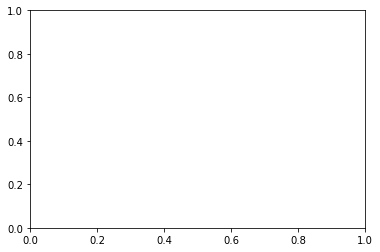

In [20]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
%matplotlib inline

def show_plot(points):
    plt.figure()
    fig, ax = plt.subplots()
    loc = ticker.MultipleLocator(base=0.2) # put ticks at regular intervals
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

show_plot(plot_losses)

In [21]:
def evaluate(sentence, max_length=MAX_LENGTH):
    sentence = normalize_string(sentence)
    input_variable = variable_from_sentence(input_lang, sentence)
    input_length = input_variable.size()[0]
    
    # Run through encoder
    encoder_hidden = encoder.init_hidden()
    encoder_outputs, encoder_hidden = encoder(input_variable, encoder_hidden)

    # Create starting vectors for decoder
    decoder_input = Variable(torch.LongTensor([[SOS_token]])) # SOS
    decoder_context = Variable(torch.zeros(1, decoder.hidden_size))

    decoder_input = decoder_input.to(device)
    decoder_context = decoder_context.to(device)

    decoder_hidden = encoder_hidden
    
    decoded_words = []
    decoder_attentions = torch.zeros(max_length, max_length)
    
    # Run through decoder
    for di in range(max_length):
        decoder_output, decoder_context, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_context, decoder_hidden, encoder_outputs)
        decoder_attentions[di,:decoder_attention.size(2)] += decoder_attention.squeeze(0).squeeze(0).cpu().data

        # Choose top word from output
        topv, topi = decoder_output.data.topk(1)
        ni = topi[0][0]
        if ni == EOS_token:
            decoded_words.append('<EOS>')
            break
        else:
            decoded_words.append(output_lang.index2word[int(ni)])
            
        # Next input is chosen word
        decoder_input = Variable(torch.LongTensor([[ni]]))
        decoder_input = decoder_input.to(device)
    
    return decoded_words, decoder_attentions[:di+1, :len(encoder_outputs)]

In [22]:
def predict(sentence):
    sentence = normalize_string(sentence)
    input_variable = variable_from_sentence(input_lang, sentence)
    input_length = input_variable.size()[0]
    
    encoder_hidden = encoder.init_hidden()
    encoder_outputs, encoder_hidden = encoder(input_variable, encoder_hidden)
    
    decoder_input = Variable(torch.LongTensor([[SOS_token]])) # SOS
    decoder_context = Variable(torch.zeros(1, decoder.hidden_size))
    
    decoder_input = decoder_input.to(device)
    decoder_context = decoder_context.to(device)

    decoder_hidden = encoder_hidden
    
    decoded_words = []
    decoder_attentions = torch.zeros(max_length, max_length)
    
    for di in range(max_length):
        decoder_output, decoder_context, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_context, decoder_hidden, encoder_outputs)

        # Choose top word from output
        topv, topi = decoder_output.data.topk(1)
        ni = topi[0][0]
        if ni == EOS_token:
            decoded_words.append('<EOS>')
            break
        else:
            decoded_words.append(output_lang.index2word[int(ni)])
            
        # Next input is chosen word
        decoder_input = Variable(torch.LongTensor([[ni]]))
        decoder_input = decoder_input.to(device)
    
    return decoded_words

In [23]:
def evaluate_randomly():
    pair = random.choice(pairs)
    
    output_words, decoder_attn = evaluate(pair[0])
    output_sentence = ' '.join(output_words)
    
    print('>', pair[0])
    print('=', pair[1])
    print('<', output_sentence)
    print('')

In [24]:
evaluate_randomly()

> он просто исчез
= it just vanished
< he just just <EOS>



C:\Users\ONIGAT~1\AppData\Local\Temp/ipykernel_24024/1211660399.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(attn_energies).unsqueeze(0).unsqueeze(0)
C:\Users\ONIGAT~1\AppData\Local\Temp/ipykernel_24024/290874258.py:38: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.log_softmax(self.out(torch.cat((rnn_output, context), 1)))


In [25]:
evaluate('привет')

C:\Users\ONIGAT~1\AppData\Local\Temp/ipykernel_24024/1211660399.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(attn_energies).unsqueeze(0).unsqueeze(0)
C:\Users\ONIGAT~1\AppData\Local\Temp/ipykernel_24024/290874258.py:38: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.log_softmax(self.out(torch.cat((rnn_output, context), 1)))


(['stop', '<EOS>'],
 tensor([[7.9100e-06, 1.2917e-06, 9.9999e-01],
         [1.5890e-16, 2.2365e-05, 9.9998e-01]]))

In [32]:
torch.save(encoder, 'encoder.pth')
torch.save(decoder, 'decoder.pth')


In [33]:
encoder_test = torch.load('encoder.pth')
decoder_test = torch.load('decoder.pth')


In [34]:
print(encoder)

EncoderRNN(
  (embedding): Embedding(95134, 500)
  (gru): GRU(500, 500, num_layers=2)
)


In [35]:
print(decoder)

AttnDecoderRNN(
  (embedding): Embedding(35713, 500)
  (gru): GRU(1000, 500, num_layers=2, dropout=0.05)
  (out): Linear(in_features=1000, out_features=35713, bias=True)
  (attn): Attn(
    (attn): Linear(in_features=500, out_features=500, bias=True)
  )
)
